In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

In [40]:
# generate (un)censored time data
np.random.seed(123)
n = 100
time = np.random.randint(100, size = n)
events = np.random.choice([0,1], size = n)
color_keys = ['blue','orange']

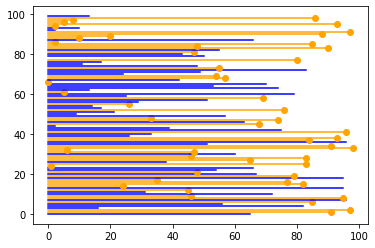

In [52]:
# line plots of censored data
for i in range(len(time)):
    x = np.arange(time[i])
    y = np.repeat(i, time[i])
    plt.plot(x,y, color = color_keys[events[i]])
    if events[i]==1:
        plt.plot(np.max(x),i, color=color_keys[events[i]], marker='o')
    
plt.show()

## Survival Functions
- Survival Probability
$$S(t) = \prod_{i=0}^{t} 1-Pr(T=i| T \geq i) = \prod_{i=0}^{t} 1- \frac{d_i}{n_i}$$

- Cummulative hazard
$$\Lambda(t) = \sum_{i=0} \frac{d_i}{n_i}$$

- Hazard
$$\lambda (t) = -\frac{S'(t)}{S(t)}$$

- Equivalences
$$\Lambda(t) = -log S(t)$$
$$S(t) = exp(-\Lambda(t))$$

In [53]:
def compute_survival_functions(events, time):
    idx_time = np.argsort(time) # sort by time
    sorted_censoring = events[idx_time]
    sorted_time = time[idx_time]
    cumsum_died = np.cumsum(sorted_censoring)
    cumsum_alive = len(sorted_censoring)-cumsum_died

    # compute survival functions
    cum_hazard = cumsum_died / cumsum_alive
    surv_prob  = np.exp(-cum_hazard)
    
    return {'cum_hazard': cum_hazard, 'surv_prob': surv_prob}

surv_funcs = compute_survival_functions(events, time)

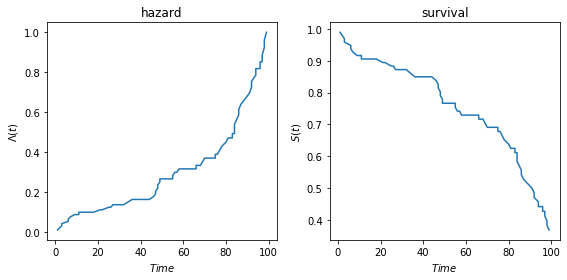

In [54]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(np.sort(time), surv_funcs['cum_hazard'])
plt.title('hazard')
plt.xlabel(r'$Time$')
plt.ylabel(r'$\Lambda(t)$')

plt.subplot(122)
plt.plot(np.sort(time), surv_funcs['surv_prob'])
plt.title('survival')
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')

plt.tight_layout()
plt.show()

In [56]:
# split data into two groups
grouping = np.random.choice(['A','B'], len(time))
timeA, eventsA = time[grouping=='A'], events[grouping=='A'] 
timeB, eventsB = time[grouping=='B'], events[grouping=='B']

# compute survival functions
surv_funcsA = compute_survival_functions(eventsA, timeA)
surv_funcsB = compute_survival_functions(eventsB, timeB)

# Logrank test (or Mantel-Cox test): 
# whether probability of an event at any point is different
lr = logrank_test(durations_A=timeA, durations_B=timeB,
                  event_observed_A=eventsA, event_observed_B=eventsB) # events observed as 1s; not observed as 0s.
lr.print_summary()

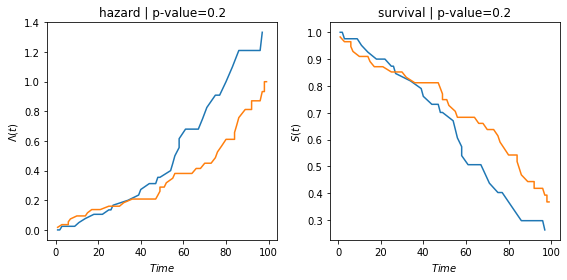

In [102]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(np.sort(timeA), surv_funcsA['cum_hazard'])
plt.plot(np.sort(timeB), surv_funcsB['cum_hazard'])
plt.title('hazard | p-value='+str(np.round(lr.p_value,2)))
plt.xlabel(r'$Time$')
plt.ylabel(r'$\Lambda(t)$')

plt.subplot(122)
plt.plot(np.sort(timeA), surv_funcsA['surv_prob'])
plt.plot(np.sort(timeB), surv_funcsB['surv_prob'])
plt.title('survival | p-value='+str(np.round(lr.p_value,2)))
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')

plt.tight_layout()
plt.show()

## compute concordance index to make performance assessment of a model

In [100]:
df = pd.DataFrame({'T': time, 'E': events})
cph = CoxPHFitter().fit(df, 'T', 'E')
concordance_index(df['T'], - cph.predict_partial_hazard(df), df['E'])

0.5

## example

In [93]:
rossi = load_rossi()
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [91]:
from lifelines.datasets import load_waltons, load_rossi

In [31]:
df = load_waltons()
df

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137
...,...,...,...
158,60.0,1,control
159,60.0,1,control
160,60.0,1,control
161,60.0,1,control


In [49]:
# check proportion of censored events
df.groupby(['E','group']).count()

T
E group       
0 control    7
1 control  122
  miR-137   34

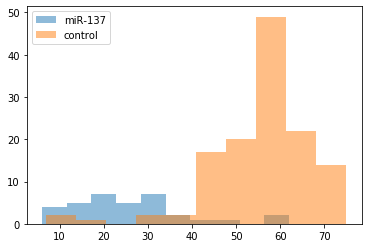

In [29]:
plt.hist(df.loc[df['group']=='miR-137','T'], alpha=0.5, label='miR-137')
plt.hist(df.loc[df['group']=='control','T'], alpha=0.5, label='control')
plt.legend()
plt.show()

In [82]:
idxMIR = df['group']=='miR-137'
miR = compute_survival_functions(events = df.loc[idxMIR,'E'].values, time = df.loc[idxMIR,'T'].values) # there is a warning because all die
idxCON = df['group']=='control'
con = compute_survival_functions(events = df.loc[idxCON,'E'].values, time = df.loc[idxCON,'T'].values)

<ipython-input-53-a310438fd777>:9: RuntimeWarning: divide by zero encountered in true_divide
  cum_hazard = cumsum_died / cumsum_alive


In [83]:
lr = logrank_test(durations_A=df.loc[idxMIR,'T'].values, durations_B=df.loc[idxCON,'T'].values,
                  event_observed_A=df.loc[idxMIR,'E'].values, event_observed_B=df.loc[idxCON,'E'].values) # events observed as 1s; not observed as 0s.
lr.print_summary()

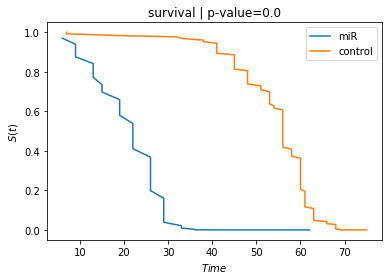

In [85]:
plt.plot(np.sort(df.loc[idxMIR,'T'].values), miR['surv_prob'], label='miR')
plt.plot(np.sort(df.loc[idxCON,'T'].values), con['surv_prob'], label='control')
plt.title('survival | p-value='+str(np.round(lr.p_value,2)))
plt.legend()
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')
plt.show()

### Automated data split
Now let's say we do not have labelled groups, we need to split the data into two so we obtain the best logrank test.

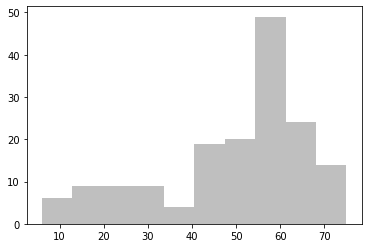

In [89]:
plt.hist(df.loc[:,'T'], alpha=0.5, color='grey')
plt.show()

In [96]:
# fit distribution of time in miR
from scipy.stats import norm
mu, std = norm.fit(df.loc[df['group']=='miR-137','T'])
prob = norm.pdf(df['T'], mu, std) # predict probability of each point

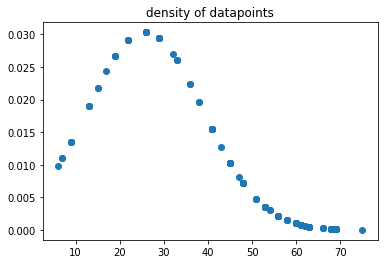

In [99]:
plt.plot(df['T'],prob, 'o')
plt.title('density of datapoints')
plt.show()

In [103]:
# classify points that are not likely to be part of the miR distribution
alpha = 0.005
df['classif'] = prob > alpha

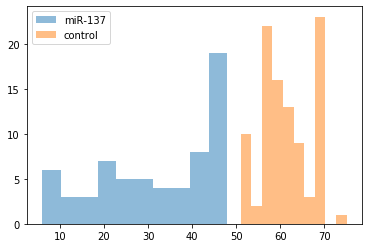

In [104]:
# show new classification
plt.hist(df.loc[df['classif'].values,'T'], alpha=0.5, label='miR-137')
plt.hist(df.loc[~df['classif'].values,'T'], alpha=0.5, label='control')
plt.legend()
plt.show()

In [105]:
idxMIR = df['classif'].values
idxCON = ~df['classif'].values
lr = logrank_test(durations_A=df.loc[idxMIR,'T'].values, durations_B=df.loc[idxCON,'T'].values,
                  event_observed_A=df.loc[idxMIR,'E'].values, event_observed_B=df.loc[idxCON,'E'].values) # events observed as 1s; not observed as 0s.
lr.print_summary()

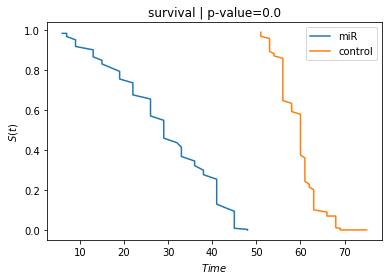

In [106]:
miR = compute_survival_functions(events = df.loc[idxMIR,'E'].values, time = df.loc[idxMIR,'T'].values) # there is a warning because all die
con = compute_survival_functions(events = df.loc[idxCON,'E'].values, time = df.loc[idxCON,'T'].values)

plt.plot(np.sort(df.loc[idxMIR,'T'].values), miR['surv_prob'], label='miR')
plt.plot(np.sort(df.loc[idxCON,'T'].values), con['surv_prob'], label='control')
plt.title('survival | p-value='+str(np.round(lr.p_value,2)))
plt.legend()
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')
plt.show()